# EV presence and consumption

Authors: Alessio Carnevale, Manuel Cattoni

In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
import warnings

In [19]:
df = pd.read_csv('data/ev_dataset.csv', delimiter=';')

This [dataset](https://data.4tu.nl/datasets/80ef3824-3f5d-4e45-8794-3b8791efbd13/1) collects 55,000 unique charging sessions from a large public parking lot in Utrecht.

In [20]:
print("Length of Dataset:", len(df))
df.info()

Length of Dataset: 55379
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55379 entries, 0 to 55378
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EV_id_x                    55379 non-null  object 
 1   start_datetime             55379 non-null  object 
 2   end_datetime               55379 non-null  object 
 3   total_energy               55379 non-null  float64
 4   rail                       55379 non-null  object 
 5   evse_uid                   55379 non-null  int64  
 6   channel                    55379 non-null  int64  
 7   capacity_kwh               3829 non-null   float64
 8   commute_km_range_min       4053 non-null   float64
 9   commute_km_range_max       4053 non-null   float64
 10  EV_brand_selfreported      4053 non-null   object 
 11  EV_model_selfreported      4053 non-null   object 
 12  capacity_kwh_selfreported  4053 non-null   object 
 13  ownership            

In [21]:
df.head()

,EV_id_x,start_datetime,end_datetime,total_energy,rail,evse_uid,channel,capacity_kwh,commute_km_range_min,commute_km_range_max,EV_brand_selfreported,EV_model_selfreported,capacity_kwh_selfreported,ownership
0,EV0,2020-08-25 11:56:02,2020-08-25 12:08:15,1.477,mennekes,600001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EV0,2020-08-25 12:20:30,2020-08-25 12:32:16,1.333,mennekes,600002,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EV0,2020-08-25 12:40:47,2020-08-25 13:01:23,2.330,mennekes,600003,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EV0,2020-08-25 13:05:31,2020-08-25 13:37:29,3.764,mennekes,600005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EV0,2020-08-25 14:03:28,2020-08-25 14:23:03,2.297,mennekes,600000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Convert start and end columns to datetime if not already
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df['end_datetime'] = pd.to_datetime(df['end_datetime'])

# Calculate duration in hours
df['duration'] = (df['end_datetime'] - df['start_datetime']).dt.total_seconds() / 3600

# Calculate average duration
avg_duration = df['duration'].mean()
print(f"Average charging duration: {avg_duration:.2f} hours")

Average charging duration: 6.55 hours


## Visualizations on Dataset

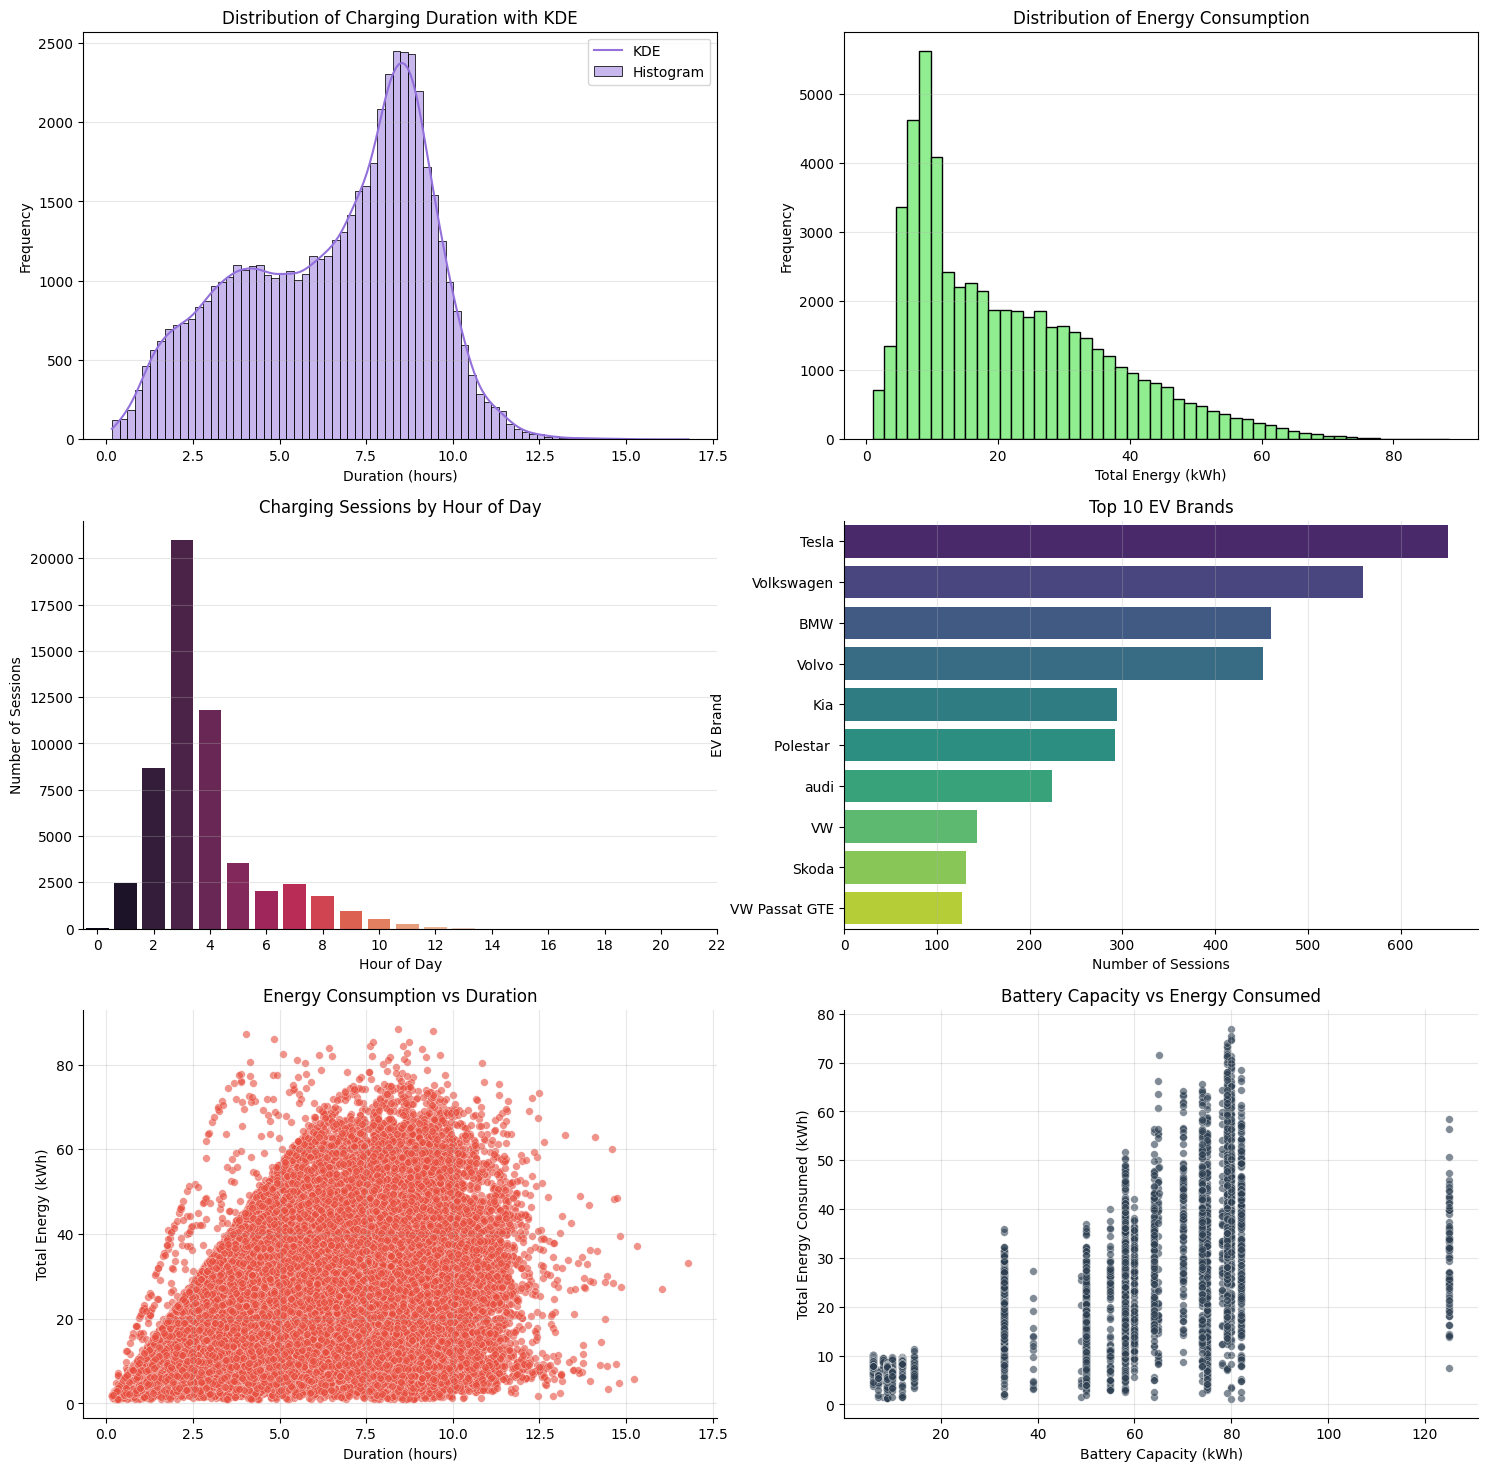

In [23]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# 1. Distribution plot of duration
sns.histplot(data=df, x='duration', kde=True, ax=axes[0, 0], color='mediumpurple', edgecolor='black')
axes[0, 0].set_title('Distribution of Charging Duration with KDE')
axes[0, 0].set_xlabel('Duration (hours)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].legend(['KDE', 'Histogram'])

# 2. Distribution of total energy consumed
axes[0, 1].hist(df['total_energy'], bins=50, edgecolor='black', color='lightgreen')
axes[0, 1].set_xlabel('Total Energy (kWh)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Energy Consumption')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Charging sessions by hour of day
df['start_hour'] = df['start_datetime'].dt.hour
hourly_sessions = df['start_hour'].value_counts().sort_index()

sns.barplot(data=pd.DataFrame({'hour': hourly_sessions.index, 'sessions': hourly_sessions.values}),
            x='hour', y='sessions', hue='hour', 
            palette='rocket', ax=axes[1, 0], saturation=0.8, legend=False)

axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Number of Sessions')
axes[1, 0].set_title('Charging Sessions by Hour of Day')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].set_xticklabels(range(0, 24, 2))
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)

# 4. Top EV brands
top_brands = df['EV_brand_selfreported'].value_counts().head(10)

sns.barplot(data=pd.DataFrame({'brand': top_brands.index, 'count': top_brands.values}),
            y='brand', x='count', hue='brand',
            palette='viridis', ax=axes[1, 1], saturation=0.8, legend=False)

axes[1, 1].set_xlabel('Number of Sessions')
axes[1, 1].set_ylabel('EV Brand')
axes[1, 1].set_title('Top 10 EV Brands')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].spines['top'].set_visible(False)
axes[1, 1].spines['right'].set_visible(False)

# 5. Energy vs Duration scatter plot
sns.scatterplot(x='duration', y='total_energy', data=df, 
                alpha=0.6, s=30, color='#e74c3c', 
                edgecolor='white', linewidth=0.3, ax=axes[2, 0])

# Styling
axes[2, 0].set_xlabel('Duration (hours)')
axes[2, 0].set_ylabel('Total Energy (kWh)')
axes[2, 0].set_title('Energy Consumption vs Duration')
axes[2, 0].grid(alpha=0.3)
axes[2, 0].spines['top'].set_visible(False)
axes[2, 0].spines['right'].set_visible(False)

# 6. Capacity vs Total Energy scatter
sns.scatterplot(x='capacity_kwh', y='total_energy', data=df, 
                alpha=0.6, s=30, color='#2c3e50', 
                edgecolor='white', linewidth=0.3, ax=axes[2, 1])

# Styling
axes[2, 1].set_xlabel('Battery Capacity (kWh)')
axes[2, 1].set_ylabel('Total Energy Consumed (kWh)')
axes[2, 1].set_title('Battery Capacity vs Energy Consumed')
axes[2, 1].grid(alpha=0.3)
axes[2, 1].spines['top'].set_visible(False)
axes[2, 1].spines['right'].set_visible(False)

## Correlation Matrix

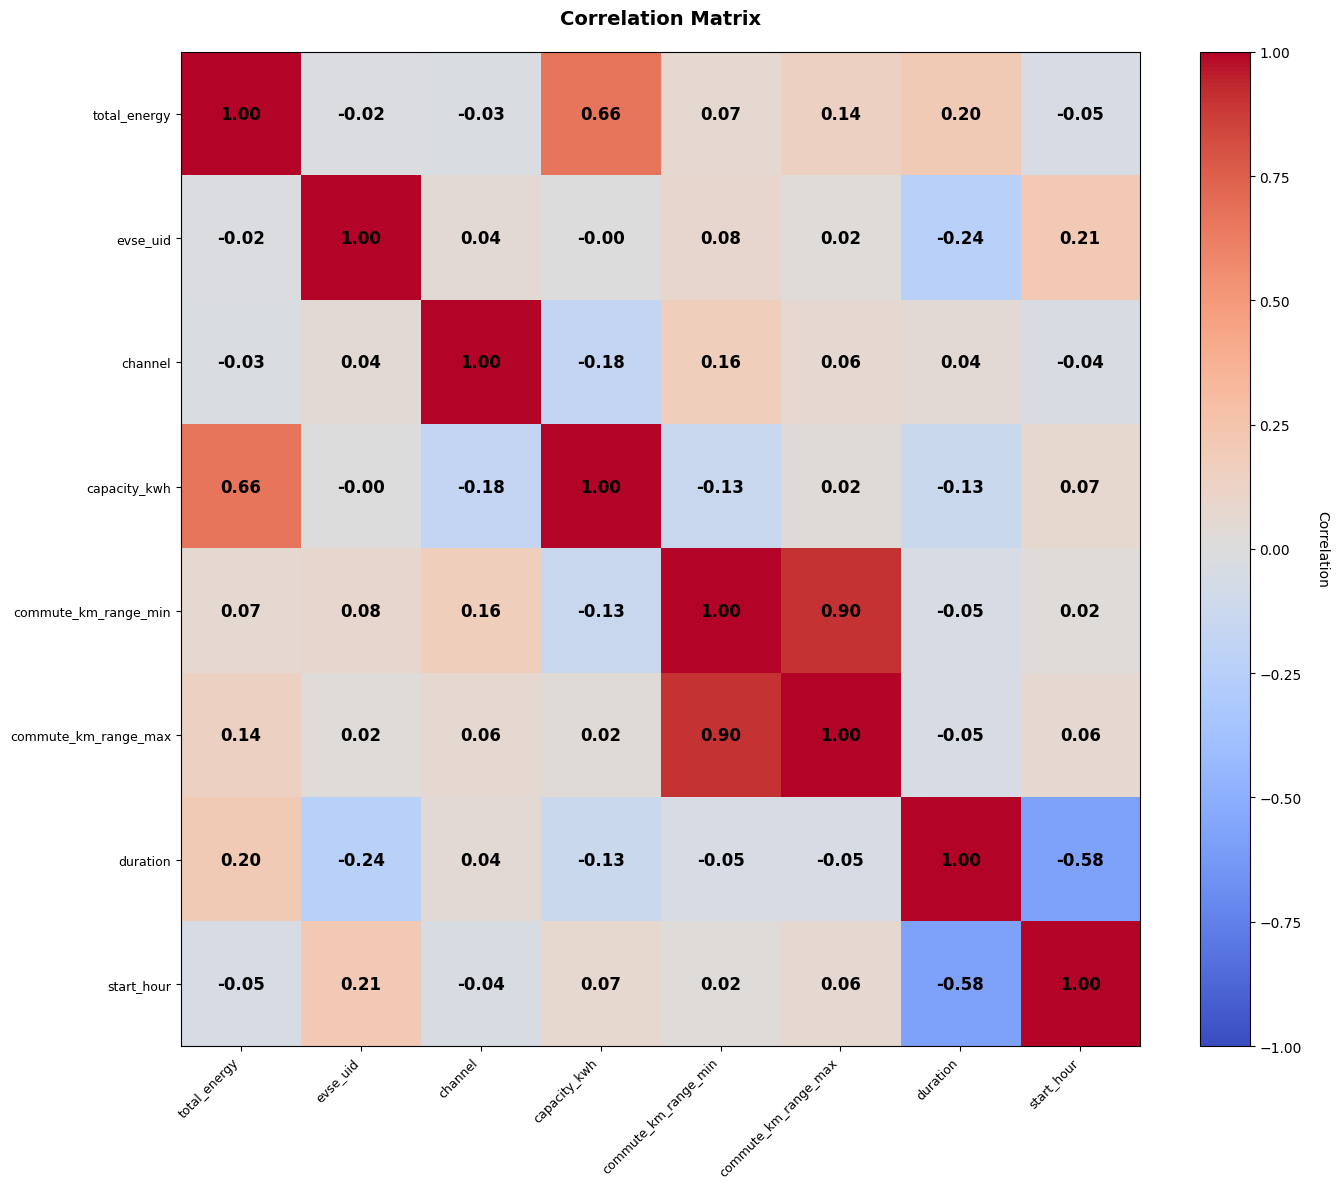

In [24]:

# Calculate correlation matrix for numeric columns
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

# Create the heatmap using imshow
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

# Set ticks and labels
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(correlation_matrix.columns, fontsize=9)

# Add text annotations for all values
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=12, weight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation', rotation=270, labelpad=20)

ax.set_title('Correlation Matrix', fontsize=14, pad=20, weight='bold')
plt.tight_layout()
plt.show()

## ACF Plot

<Figure size 1000x400 with 0 Axes>

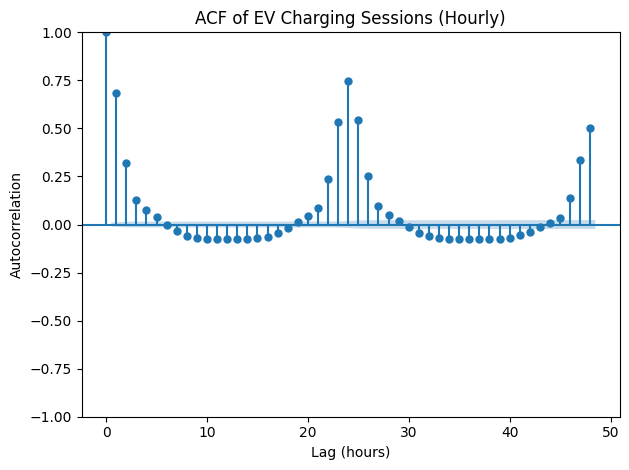

In [25]:
ts = (
    df
    .set_index('start_datetime')
    .resample('h')
    .size()
)

plt.figure(figsize=(10, 4))
plot_acf(ts, lags=48)
plt.title("ACF of EV Charging Sessions (Hourly)")
plt.xlabel("Lag (hours)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()


# Dataset transformation

The code assumes that the charging power is constant throughout the session.$$\text{Average Power (kW)} = \frac{\text{Total Energy (kWh)}}{\text{Session Duration (h)}}$$

In [26]:
def create_time_series_optimized(df, group_col=None):
    """
    Converts charging session data into an hourly time series.
    Logic: Distributes energy proportionally based on the exact overlap 
    between the session duration and the specific hour.
    """    
    # 1. Calculate average power (kW) for each session
    df = df.copy()
    duration_h = (df['end_datetime'] - df['start_datetime']).dt.total_seconds() / 3600
    
    # Division by zero or extremely short durations
    df['avg_power_kw'] = np.where(duration_h > 0.001, df['total_energy'] / duration_h, 0)
    
    records = []
    
    # 2. iterate
    for row in df.itertuples():
        t_start = row.start_datetime
        t_end = row.end_datetime
        
        # Define the start and end hour buckets
        start_bucket = t_start.floor('h')
        end_bucket = t_end.ceil('h')
        
        # Generate all hourly timestamps involved in this session
        buckets = pd.date_range(start_bucket, end_bucket, freq='h', inclusive='left')
        
        for bucket in buckets:
            # Define the end of the current hour bucket
            bucket_end = bucket + pd.Timedelta(hours=1)
            
            # Calculate the exact time overlap in this specific hour
            # Overlap is the intersection: [max(start), min(end)]
            overlap_start = max(bucket, t_start)
            overlap_end = min(bucket_end, t_end)
            
            seconds_active = (overlap_end - overlap_start).total_seconds()
            
            if seconds_active > 0:
                hours_active = seconds_active / 3600
                
                # Energy = Time Active (h) * Power (kW)
                consumption = hours_active * row.avg_power_kw
                
                record = {
                    'timestamp': bucket,
                    'consumption': consumption,
                    'presence': 1  # flag (active during this hour ?)
                }
                
                # column (e.g., 'rail') if requested
                if group_col:
                    record[group_col] = getattr(row, group_col)
                    
                records.append(record)

    return pd.DataFrame(records)

In [27]:
# Generate the new staset
df_expanded = create_time_series_optimized(df, group_col='rail')

# 1. Fleet TS (aggregation)
fleet_ts = df_expanded.groupby('timestamp').agg({
    'presence': 'sum',
    'consumption': 'sum'
}).resample('h').asfreq().fillna(0)

# 2. Rail TS (Unstacking)
rail_ts = df_expanded.groupby(['timestamp', 'rail']).agg({
    'presence': 'sum',
    'consumption': 'sum'
}).unstack(fill_value=0)

print("-" * 40)
print("Transformation Complete.")
print(f"Fleet TS Shape: {fleet_ts.shape}")
print("Fleet TS Head:")
print(fleet_ts.head())

print("--- Energy Conservation Check ---")

# Calculate totas
total_energy_raw = df['total_energy'].sum()
total_energy_ts = fleet_ts['consumption'].sum()
diff = total_energy_ts - total_energy_raw

print(f"Total Energy in Raw Dataset: {total_energy_raw:,.2f} kWh")
print(f"Total Energy in Time Series: {total_energy_ts:,.2f} kWh")
print(f"Difference: {diff:,.2f} kWh")

# Validation logic
if abs(diff) < 1.0:
    print("Result: Energy is conserved perfectly.")
else:
    print("Result: WARNING. Significant energy discrepancy found.")

----------------------------------------
Transformation Complete.
Fleet TS Shape: (35982, 2)
Fleet TS Head:
                     presence  consumption
timestamp                                 
2020-08-25 11:00:00       1.0     0.479572
2020-08-25 12:00:00       3.0     4.503964
2020-08-25 13:00:00       2.0     3.920464
2020-08-25 14:00:00       2.0     7.184000
2020-08-25 15:00:00       0.0     0.000000
--- Energy Conservation Check ---
Total Energy in Raw Dataset: 1,193,202.00 kWh
Total Energy in Time Series: 1,193,202.00 kWh
Difference: 0.00 kWh
Result: Energy is conserved perfectly.


In [28]:
def prepare_features(df_ts):
    df = df_ts.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Lag features: the value from the previous hour or the previous day
    df['consumption_lag_24'] = df['consumption'].shift(24) # Consumo stessa ora ieri
    df['presence_lag_24'] = df['presence'].shift(24)
    
    return df.dropna()

fleet_features = prepare_features(fleet_ts)

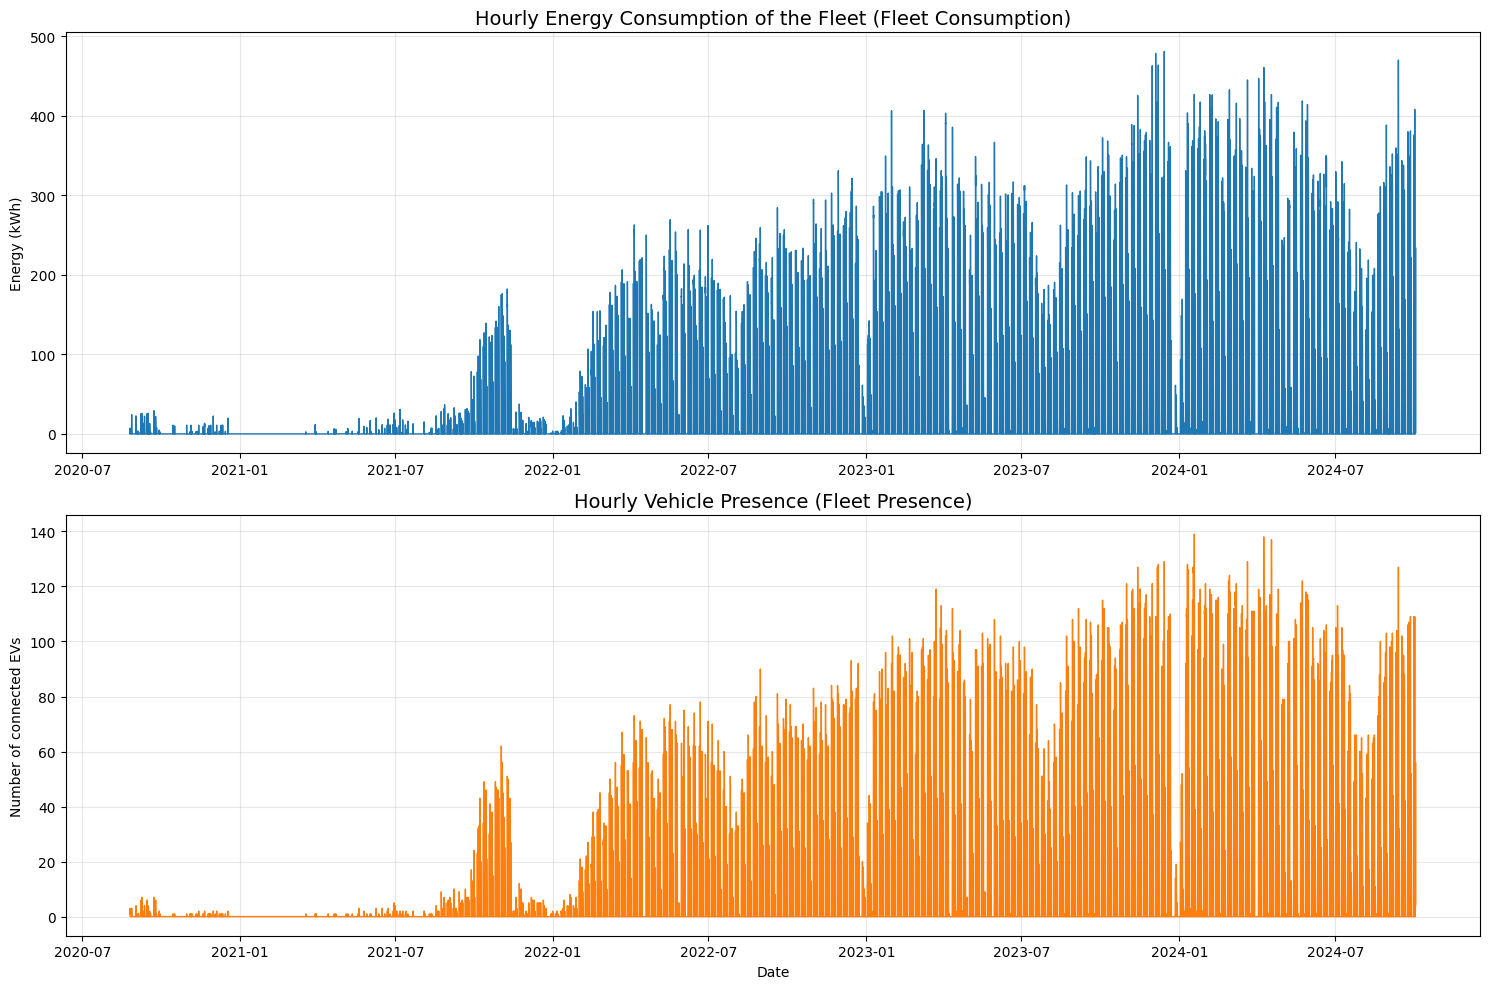

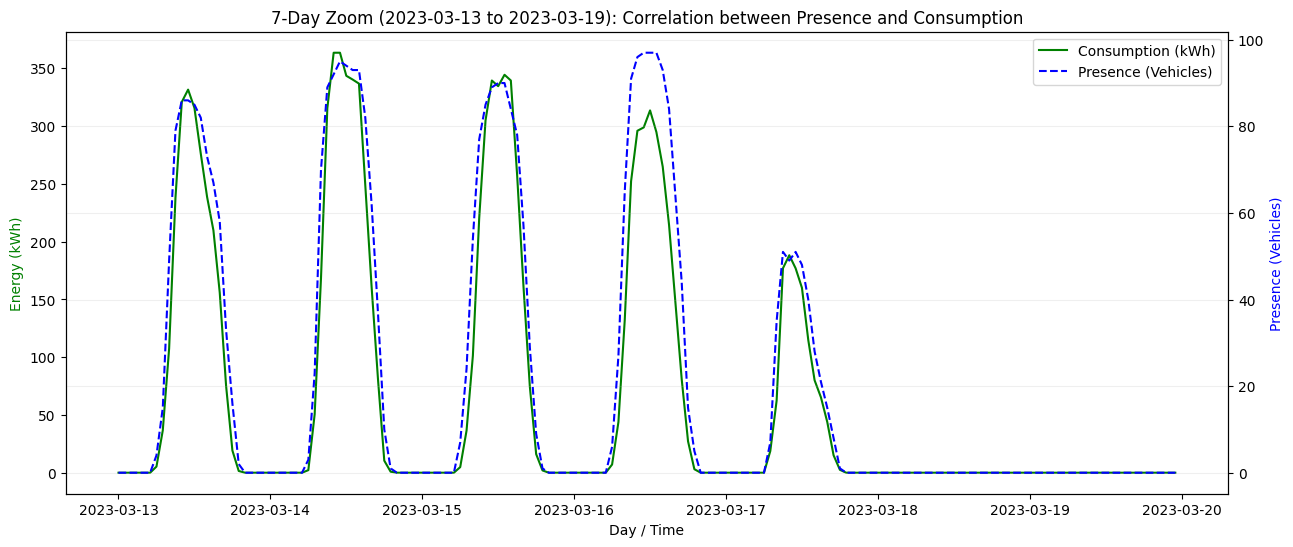

In [29]:
plt.figure(figsize=(15, 10))

# plot 1: total eergy consumption 
plt.subplot(2, 1, 1)
plt.plot(fleet_ts.index, fleet_ts['consumption'], color='tab:blue', linewidth=1)
plt.title('Hourly Energy Consumption of the Fleet (Fleet Consumption)', fontsize=14)
plt.ylabel('Energy (kWh)')
plt.grid(True, alpha=0.3)

# Plot 2: veichle presence
plt.subplot(2, 1, 2)
plt.plot(fleet_ts.index, fleet_ts['presence'], color='tab:orange', linewidth=1)
plt.title('Hourly Vehicle Presence (Fleet Presence)', fontsize=14)
plt.ylabel('Number of connected EVs')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# zoom to a  week in March 2023 
# from Mon 13 March to Sunday, 19th
start_date = '2023-03-13'
end_date = '2023-03-19'
sample_week = fleet_ts.loc[start_date:end_date]

fig, ax1 = plt.subplots(figsize=(15, 6))

ax2 = ax1.twinx()
# Consumption on the primary Y (left)
ax1.plot(sample_week.index, sample_week['consumption'], 'g-', label='Consumption (kWh)')
# Presence on the secondary Y (right)
ax2.plot(sample_week.index, sample_week['presence'], 'b--', label='Presence (Vehicles)')

ax1.set_xlabel('Day / Time')
ax1.set_ylabel('Energy (kWh)', color='g')
ax2.set_ylabel('Presence (Vehicles)', color='b')
plt.title(f'7-Day Zoom ({start_date} to {end_date}): Correlation between Presence and Consumption')
plt.grid(True, alpha=0.2)

# Combining legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

In [30]:
for rail in ['B', 'C', 'E', 'H', 'J']:
    ts = rail_ts['consumption'][rail]
    train = ts.loc[:'2023-03-15 23:00:00']
    
    print(f"\nRail {rail}:")
    print(f"  Mean: {train.mean():.2f}")
    print(f"  Std: {train.std():.2f}")
    print(f"  Min: {train.min():.2f}")
    print(f"  Max: {train.max():.2f}")
    print(f"  CV (Std/Mean): {train.std()/train.mean():.4f}")
    print(f"  % zeros: {(train == 0).sum() / len(train) * 100:.1f}%")



Rail B:
  Mean: 14.47
  Std: 16.02
  Min: 0.00
  Max: 98.39
  CV (Std/Mean): 1.1068
  % zeros: 26.6%

Rail C:
  Mean: 4.47
  Std: 8.06
  Min: 0.00
  Max: 66.49
  CV (Std/Mean): 1.8038
  % zeros: 54.8%

Rail E:
  Mean: 20.68
  Std: 23.18
  Min: 0.00
  Max: 107.49
  CV (Std/Mean): 1.1206
  % zeros: 19.5%

Rail H:
  Mean: 18.50
  Std: 21.61
  Min: 0.00
  Max: 115.64
  CV (Std/Mean): 1.1682
  % zeros: 28.1%

Rail J:
  Mean: 4.16
  Std: 7.82
  Min: 0.00
  Max: 45.14
  CV (Std/Mean): 1.8771
  % zeros: 61.7%


## Stationary test

In [31]:
def check_stationarity_flexible(series, name, lags_to_test=[24, 168]):
    """
    Checks stationarity for Raw data, and then for specific Seasonal Lags.
    """
    print(f"======= Stationarity Analysis: {name} =======")
    
    # Helper function
    def run_tests(data, desc):
        # ADF Test 
        adf = adfuller(data.dropna(), autolag='AIC')
        
        # KPSS Test
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            kpss_res = kpss(data.dropna(), regression='c', nlags="auto")
            
        print(f'   ADF p-value:  {adf[1]:.4f}')
        print(f'   KPSS p-value: {kpss_res[1]:.4f}')
        
        is_stat = (adf[1] < 0.05) and (kpss_res[1] > 0.05)
        print(f"   Result: {'STATIONARY' if is_stat else 'NON-STATIONARY'}")
        return is_stat

    # 1. Test raw data
    if run_tests(series, "Raw Data"):
        print("Conclusion: Raw data is stationary.")
        print("=" * 60)
        return

    # 2. Test seasonal differences (24 and 168)
    for lag in lags_to_test:
        diff_series = series.diff(lag).dropna()
        if run_tests(diff_series, f"Seasonally Differenced (Lag {lag})"):
            print(f"\nConclusion: Series becomes stationary with Lag {lag} differencing.")
            print(f"Insight: The main cycle is {lag} hours.")
            print("=" * 60)
            return

    print("\nConclusion: Series is still non-stationary or complex.")
    print("=" * 60)

# test with boyh 1day (24h) and 1 week (168h)
check_stationarity_flexible(fleet_ts['consumption'], "Fleet Consumption", lags_to_test=[24, 168])

======= Stationarity Analysis: Fleet Consumption =======
   ADF p-value:  0.0000
   KPSS p-value: 0.0100
   Result: NON-STATIONARY
   ADF p-value:  0.0000
   KPSS p-value: 0.1000
   Result: STATIONARY

Conclusion: Series becomes stationary with Lag 24 differencing.
Insight: The main cycle is 24 hours.


Interpretation of Stationarity Tests
The stationarity analysis reveals a critical insight into the data structure:

Raw Data Conflict: The raw series shows conflicting results (ADF rejects unit root, but KPSS rejects stationarity). This is a classic signature of Seasonal Non-Stationarity. The mean is not constant because it follows a strong daily pattern (0 kWh at night, peak during the day).

Effect of Differencing: Applying a 24-hour seasonal difference (Lag 24) makes the series strictly stationary (KPSS p-value > 0.05). This confirms that the primary driver of the series is the daily cycle.

Modeling Strategy
Since the non-stationarity is driven by seasonality, we do not need to difference the target variable for the Machine Learning model (which would require complex inversion steps).

Instead, we will capture this structure by Feature Engineering:

We will introduce Lag Features (specifically Lag_24 and Lag_168) as input variables.

This allows the XGBoost model to learn the daily and weekly seasonality directly from the raw data, effectively "stationarizing" the problem internally without altering the target consumption values.

## Simple models

Functions

In [32]:
def cast_df(y, df):
    h = len(y)
    return pd.DataFrame(y, index=pd.date_range(
        start=df.index[-1] + pd.Timedelta(hours=1), periods=h, freq='h'))

def naive(x, h): 
    return cast_df(np.repeat(x.iloc[-1], h), x)

def mean_fc(x, h): 
    return cast_df(np.repeat(x.mean(), h), x)

def seasonal_naive(x, h, m=24):
    values = x.iloc[-m:].values
    y_hat = np.tile(values, int(np.ceil(h/m)))[:h]
    return cast_df(y_hat, x)

def calculate_nmae(y_true, y_pred, y_train_mean):
    # mae = np.mean(np.abs(y_true - y_pred))
    # mae_baseline = np.mean(np.abs(y_true - y_train_mean))
    # return mae / mae_baseline if mae_baseline != 0 else np.nan
    mae = np.mean(np.abs(y_true - y_pred))
    mae_baseline = np.mean(np.abs(y_true - np.mean(y_true)))  
    return mae / mae_baseline if mae_baseline != 0 else np.nan

In [33]:
def run_pipeline(target_name, ts_data, color, split_date='2023-03-15 23:00:00', h_ahead=24):
    print(f"\n--- Running for: {target_name.upper()} ---")
    
    bench_results = {}

    for rail in ts_data.columns:
        ts = ts_data[rail]
        train = ts.loc[:split_date]
        test = ts.loc[pd.to_datetime(split_date) + pd.Timedelta(hours=1):].iloc[:h_ahead]
        
        if len(test) < h_ahead: 
            continue
        
        y_true = test.values.ravel()
        y_train_mean = train.mean()
        
        bench_results[rail] = {
            'Naive': calculate_nmae(y_true, naive(train, h_ahead).values.ravel(), y_train_mean),
            'Mean': calculate_nmae(y_true, mean_fc(train, h_ahead).values.ravel(), y_train_mean),
            'S_Naive': calculate_nmae(y_true, seasonal_naive(train, h_ahead).values.ravel(), y_train_mean)
        }
    
    df_bench = pd.DataFrame(bench_results).T
    print(f"Processed {len(bench_results)} rails")
    
    return df_bench


def get_best_model(rail, bench_df):
    best = bench_df.loc[rail].idxmin()
    return best, bench_df.loc[rail, best]

def rolling_window_eval(ts_data, h_ahead=24, window_size=168):
    """Evaluate over multiple time windows"""
    results = []
    
    for i in range(len(ts_data) - h_ahead - window_size, len(ts_data) - h_ahead, h_ahead):
        train = ts_data.iloc[:i]
        test = ts_data.iloc[i:i+h_ahead]
        
        fc = seasonal_naive(train, h_ahead)
        nmae = calculate_nmae(test.values, fc.values.ravel(), train.mean())
        results.append(nmae)
    
    return np.mean(results), np.std(results)

### Execution for the 2 time series


--- Running for: CONSUMPTION ---
Processed 15 rails

--- Running for: PRESENCE ---
Processed 15 rails

FINAL SELECTION PER RAIL
Rail: B            | Best Consumption: Mean     (nMAE: 1.00374) | Best Presence: Mean     (nMAE: 1.00335)
Rail: C            | Best Consumption: Mean     (nMAE: 1.02337) | Best Presence: Mean     (nMAE: 1.07433)
Rail: E            | Best Consumption: Mean     (nMAE: 1.03314) | Best Presence: Mean     (nMAE: 1.03573)
Rail: H            | Best Consumption: Mean     (nMAE: 1.08211) | Best Presence: Mean     (nMAE: 1.14158)
Rail: J            | Best Consumption: S_Naive  (nMAE: 1.06328) | Best Presence: Mean     (nMAE: 1.41103)
Train: 2020-08-25 11:00:00 to 2023-03-15 23:00:00
Test:  2023-03-16 00:00:00 to 2023-03-16 23:00:00


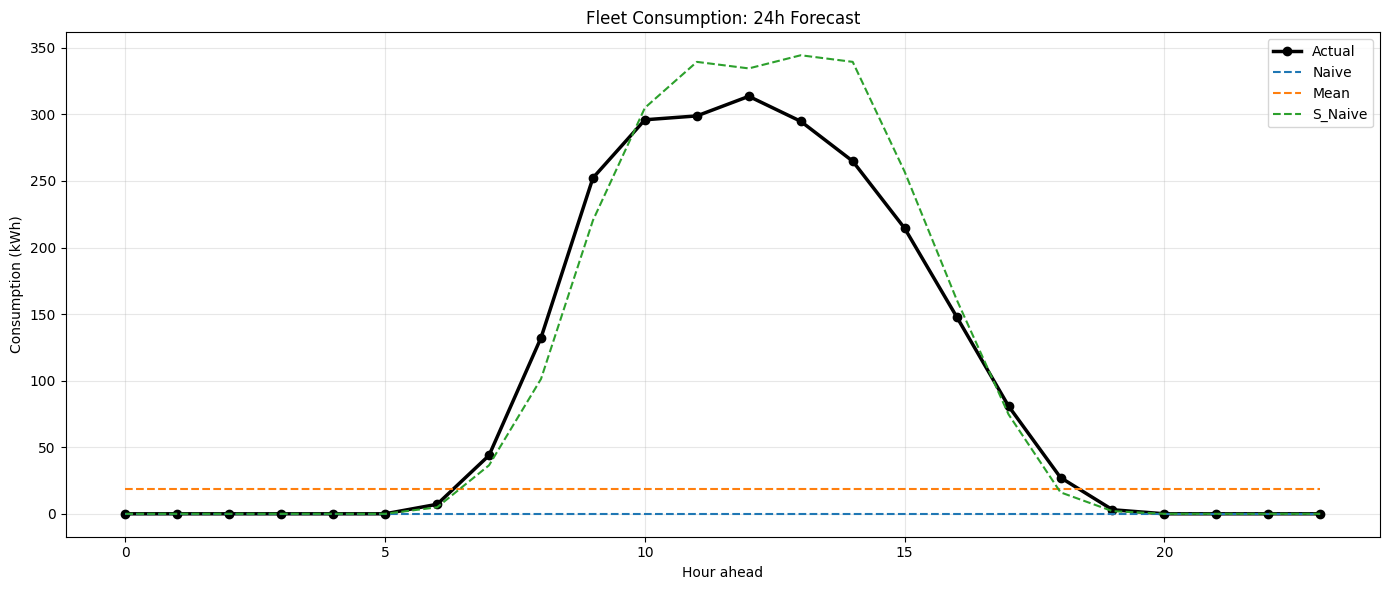

In [34]:
# execution for both series
df_bench_c = run_pipeline('consumption', rail_ts['consumption'], 'green')
df_bench_p = run_pipeline('presence', rail_ts['presence'], 'blue')

# 5. MODEL SELECTION 
print("\n" + "="*60)
print("FINAL SELECTION PER RAIL")
print("="*60)

for rail in rail_ts['consumption'].columns[:5]:
    best_c, nmae_c = get_best_model(rail, df_bench_c)
    best_p, nmae_p = get_best_model(rail, df_bench_p)
    print(f"Rail: {rail:12} | Best Consumption: {best_c:8} (nMAE: {nmae_c:.5f}) | Best Presence: {best_p:8} (nMAE: {nmae_p:.5f})")

# Plot: Fleet Consumption Forecast
split_date = '2023-03-15 23:00:00'
h_ahead = 24

train_f = fleet_ts['consumption'].loc[:split_date]

test_f = fleet_ts['consumption'].loc[pd.to_datetime(split_date) + pd.Timedelta(hours=1):].iloc[:h_ahead]

print(f"Train: {train_f.index[0]} to {train_f.index[-1]}")
print(f"Test:  {test_f.index[0]} to {test_f.index[-1]}")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(test_f.values, marker='o', label='Actual', linewidth=2.5, color='black', markersize=6)
ax.plot(naive(train_f, h_ahead).values, linestyle='--', label='Naive', linewidth=1.5)
ax.plot(mean_fc(train_f, h_ahead).values, linestyle='--', label='Mean', linewidth=1.5)
ax.plot(seasonal_naive(train_f, h_ahead).values, linestyle='--', label='S_Naive', linewidth=1.5)
ax.set_title('Fleet Consumption: 24h Forecast')
ax.set_xlabel('Hour ahead')
ax.set_ylabel('Consumption (kWh)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\manuc\AppData\Local\Temp\ipykernel_10572\3174168849.py:25: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_model_name = df_bench_c.loc[rail].idxmin()
C:\Users\manuc\AppData\Local\Temp\ipykernel_10572\3174168849.py:25: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_model_name = df_bench_c.loc[rail].idxmin()
C:\Users\manuc\AppData\Local\Temp\ipykernel_10572\3174168849.py:25: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_model_name = df_bench_c.loc[rail].idxmin()
C:\Users\manuc\AppData\Local\Temp\ipykernel_10572\3174168849.py:25: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a 

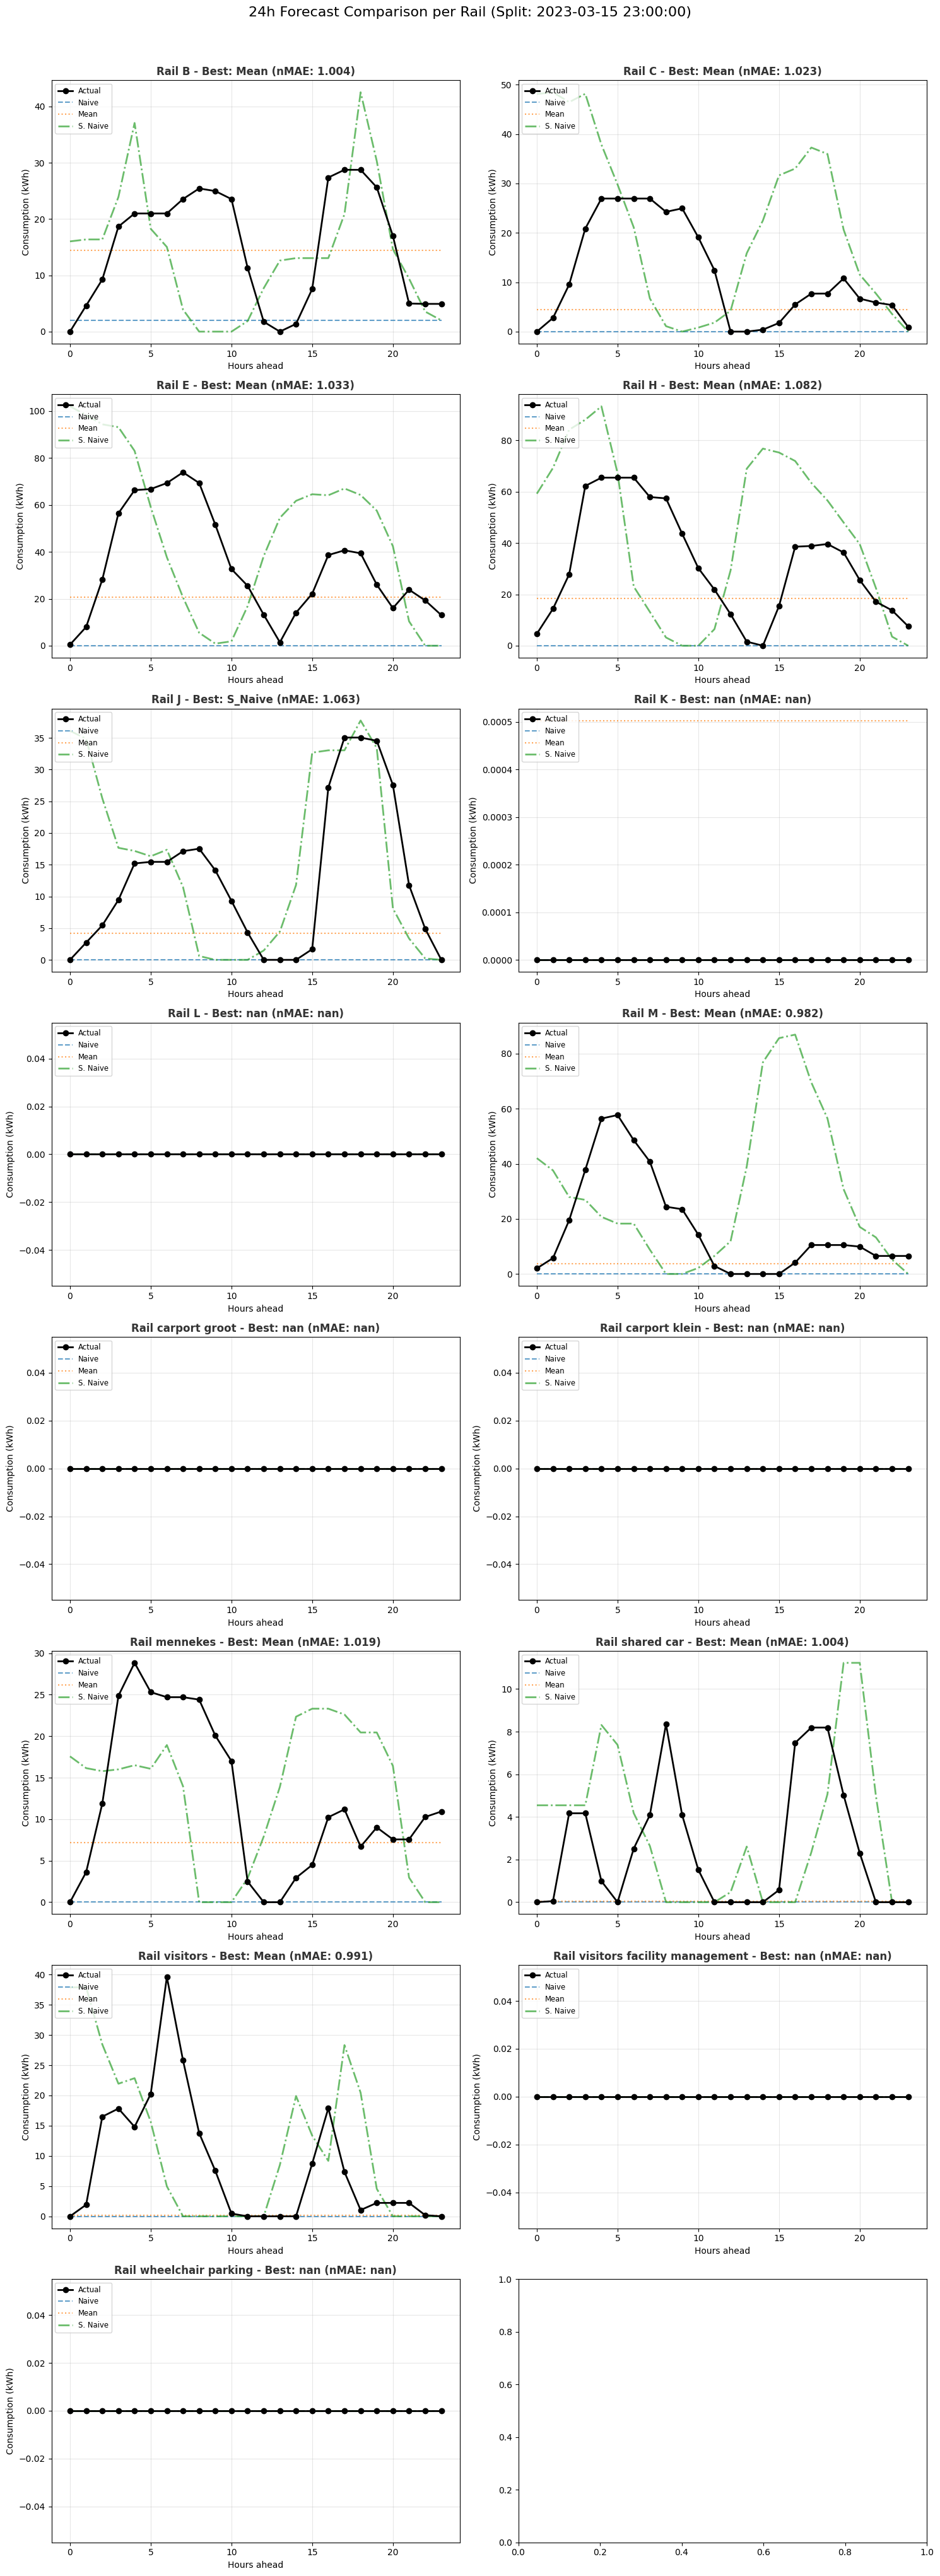

In [ ]:
rails_to_plot = rail_ts['consumption'].columns

n_cols = 2
n_rows = (len(rails_to_plot) + 1) // n_cols 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() 

split_date = '2023-03-15 23:00:00'
h_ahead = 24

for i, rail in enumerate(rails_to_plot):
    ax = axes[i]
    
    ts = rail_ts['consumption'][rail]
    train = ts.loc[:split_date]
    test = ts.loc[pd.to_datetime(split_date) + pd.Timedelta(hours=1):].iloc[:h_ahead]

    # Forecast
    f_naive = naive(train, h_ahead)
    f_mean = mean_fc(train, h_ahead)
    f_snaive = seasonal_naive(train, h_ahead)
    
    # Recover best model and nMAE from the previously calculated dataframe
    best_model_name = df_bench_c.loc[rail].idxmin()
    best_score = df_bench_c.loc[rail].min()
    
    # Plotting
    ax.plot(np.arange(h_ahead), test.values, 'o-', color='black', label='Actual', linewidth=2, zorder=5)
    
    # Baselines
    ax.plot(np.arange(h_ahead), f_naive.values, '--', label='Naive', alpha=0.7)
    ax.plot(np.arange(h_ahead), f_mean.values, ':', label='Mean', alpha=0.7)
    ax.plot(np.arange(h_ahead), f_snaive.values, '-.', label='S. Naive', alpha=0.7, linewidth=2)
    
    # Styling
    ax.set_title(f"Rail {rail} - Best: {best_model_name} (nMAE: {best_score:.3f})", 
                 fontsize=12, fontweight='bold', color='#333333')
    ax.set_ylabel('Consumption (kWh)')
    ax.set_xlabel('Hours ahead')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize='small')


plt.tight_layout()
plt.suptitle(f"24h Forecast Comparison per Rail (Split: {split_date})", y=1.02, fontsize=16)
plt.show()

CONSUMPTION RESULTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Mean forecast dominates: 8/9 valid rails use Mean as best model
• S_Naive competitive only on Rail J (nMAE=1.0633 vs Mean=1.1017)
  → Reason: Rail J has high variability; daily cycle repetition helps
  
• Best performing rails:
  - Rail M: nMAE=0.9818 (Mean beats baseline by ~2%)
  - Rail visitors: nMAE=0.9906 (Mean outperforms)
  - Rail shared car: nMAE=1.0039 (Mean nearly ties with baseline)

• Worst performing rails:
  - Rail H: nMAE=1.0821 (Mean struggles with high volatility)
  - Rail E: nMAE=1.0331 (Unpredictable EV arrivals)

KEY INSIGHT (Fleet Level Plot):
The forecast completely fails on day misalignment. S_Naive predicts yesterday's
cycle, but today has completely different demand:
  - Hours 0-12: Actual HIGH, S_Naive predicts LOW (yesterday was low)
  - Hours 12-20: Actual LOW, S_Naive predicts HIGH (yesterday was high)
This explains why Mean (global average) often outperforms S_Naive.

PRESENCE RESULTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Mean dominates even more strongly than Consumption
• All valid rails use Mean as best model
• Best: mennekes (nMAE=0.9322)
• Worst: Rail J (nMAE=1.4110 - highly erratic presence)

RESIDUAL ANALYSIS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Ljung-Box p-value: 0.000109 << 0.05
  → Residuals are NOT white noise
  → Significant autocorrelation remains
  → Simple baselines don't capture all temporal structure

INTERPRETATION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ Mean forecast provides solid baseline (nMAE ~0.98-1.10 for consumption)
✓ All rails beat Naive persistent (no zero-locking failures)
✗ nMAE > 1.0 for most rails → Room for improvement with ML models
✗ Strong autocorrelation suggests ARIMA/SARIMA could help

# SARIMA

FATTO TUTTO CON AI -> DA RIFARE

In [50]:
# import statsmodels.api as sm
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def run_sarima_pipeline(ts, target_name, order=(1,0,1), seasonal_order=(1,1,1,24), h_ahead=24, split_date='2023-03-15 23:00:00'):
#     """
#     Fits SARIMA, predicts 24h ahead, and returns probabilistic forecast.
#     Optimized to prevent MemoryError.
#     """
#     # 1. Split Train/Test
#     train = ts.loc[:split_date]
#     test = ts.loc[pd.to_datetime(split_date) + pd.Timedelta(hours=1):].iloc[:h_ahead]
    
#     # --- MEMORY FIX: Truncate history ---
#     # SARIMA con stagionalità 24 è pesante. Usiamo solo gli ultimi 3 mesi (circa 2000 ore)
#     # per il training. I dati più vecchi sono irrilevanti per il one-step-ahead forecast.
#     if len(train) > 2000:
#         print(f"   -> Reducing training size from {len(train)} to last 2000 hours for memory efficiency...")
#         train = train.iloc[-2000:]
    
#     # 2. Fit Model
#     model = sm.tsa.statespace.SARIMAX(train, 
#                                       order=order, 
#                                       seasonal_order=seasonal_order, 
#                                       enforce_stationarity=False, 
#                                       enforce_invertibility=False)
    
#     print(f"Fitting SARIMA for {target_name}...")
    
#     # --- MEMORY FIX: low_memory=True ---
#     results = model.fit(disp=False, low_memory=True)
    
#     # 3. Forecast Probabilistico
#     forecast_obj = results.get_forecast(steps=h_ahead)
#     pred_mean = forecast_obj.predicted_mean
#     conf_int = forecast_obj.conf_int(alpha=0.05) # 95% CI
    
#     # Align indexes
#     pred_mean.index = test.index
#     conf_int.index = test.index
    
#     # 4. Calc Metrics
#     mae = np.mean(np.abs(test - pred_mean))
    
#     return {
#         'model': results,
#         'pred': pred_mean,
#         'conf_int': conf_int,
#         'test': test,
#         'mae': mae
#     }

# def plot_probabilistic_forecast(res_dict, title):
#     """Generates the plot required by the challenge"""
#     plt.figure(figsize=(14, 6))
    
#     # Plot recent training data (last 72h)
#     # Recuperiamo gli ultimi dati usati dal modello
#     history_to_plot = res_dict['model'].data.endog[-72:]
#     history_index = res_dict['model'].data.dates[-72:]
    
#     plt.plot(history_index, history_to_plot, label='History (last 72h)')
#     plt.plot(res_dict['test'].index, res_dict['test'], 'ko-', linewidth=2, label='Actual')
    
#     # Forecast
#     plt.plot(res_dict['pred'].index, res_dict['pred'], 'r--', linewidth=2, label='Forecast')
    
#     # Probabilistic Interval (Requisito Challenge)
#     plt.fill_between(res_dict['conf_int'].index, 
#                      res_dict['conf_int'].iloc[:,0], 
#                      res_dict['conf_int'].iloc[:,1], 
#                      color='pink', alpha=0.4, label='95% Confidence Interval')
    
#     plt.title(f"{title} | MAE: {res_dict['mae']:.2f}", fontsize=14)
#     plt.legend(loc='upper left')
#     plt.grid(True, alpha=0.3)
#     plt.show()

# # --- ESECUZIONE ---

# # 1. FLEET TOTAL (Probabilistic required)
# sarima_fleet_c = run_sarima_pipeline(fleet_ts['consumption'], "Fleet Consumption")
# plot_probabilistic_forecast(sarima_fleet_c, "Fleet Consumption (SARIMA)")

# sarima_fleet_p = run_sarima_pipeline(fleet_ts['presence'], "Fleet Presence")
# plot_probabilistic_forecast(sarima_fleet_p, "Fleet Presence (SARIMA)")

# # 2. LOOP SUI RAIL (Top 2 rails demonstration)
# print("\n" + "="*50)
# print("Running SARIMA on Rails (Demonstration on B and E)...")

# for rail in ['B', 'E']:
#     # Blocco try-except per evitare che un errore su un rail fermi tutto il notebook
#     try:
#         res = run_sarima_pipeline(rail_ts['consumption'][rail], f"Rail {rail}", order=(1,0,1), seasonal_order=(1,1,1,24))
#         print(f"Rail {rail} MAE: {res['mae']:.2f}")
        
#         # Facoltativo: se vuoi plottare anche i rail, decommenta la riga sotto
#         # plot_probabilistic_forecast(res, f"Rail {rail}")
#         print("-" * 30)
        
#     except Exception as e:
#         print(f"Error on Rail {rail}: {e}")

In [ ]:
# print(sarima_fleet_c['conf_int'].head())

                     lower consumption  upper consumption
timestamp                                                
2023-03-16 00:00:00                NaN                NaN
2023-03-16 01:00:00                NaN                NaN
2023-03-16 02:00:00                NaN                NaN
2023-03-16 03:00:00                NaN                NaN
2023-03-16 04:00:00                NaN                NaN


>>> Starting Execution with Robust Fixes...

Fitting SARIMA for Fleet Consumption...
   ⚠️ Warning: Statsmodels returned NaN for CIs. Calculating Empirical Interval...

--- RESULTS: Fleet Consumption ---
MAE: 28.7855
First 5 predictions vs Actual:
                     Forecast  Actual  Diff
timestamp                                  
2023-03-16 00:00:00       0.0     0.0   0.0
2023-03-16 01:00:00       0.0     0.0   0.0
2023-03-16 02:00:00       0.0     0.0   0.0
2023-03-16 03:00:00       0.0     0.0   0.0
2023-03-16 04:00:00       0.0     0.0   0.0


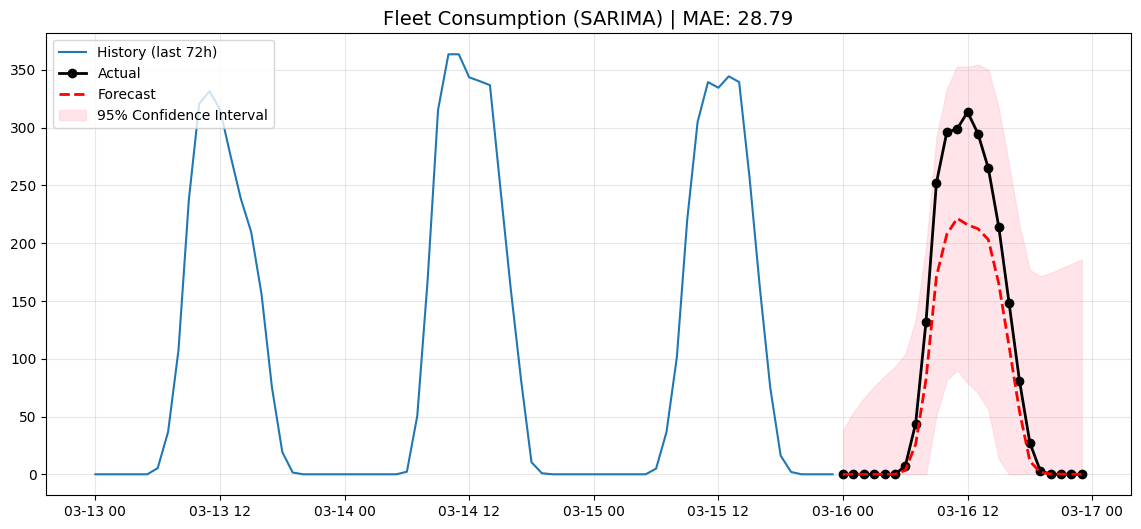



Fitting SARIMA for Rail B...


C:\Users\manuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\manuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\manuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


   ⚠️ Warning: Statsmodels returned NaN for CIs. Calculating Empirical Interval...

--- RESULTS: Rail B Consumption ---
MAE: 9.5442
First 5 predictions vs Actual:
                     Forecast     Actual       Diff
timestamp                                          
2023-03-16 06:00:00  3.888532   0.000000   3.888532
2023-03-16 07:00:00  5.834145   4.623064   1.211081
2023-03-16 08:00:00  8.299067   9.263902  -0.964835
2023-03-16 09:00:00  9.531901  18.665196  -9.133295
2023-03-16 10:00:00  9.423615  20.992575 -11.568960


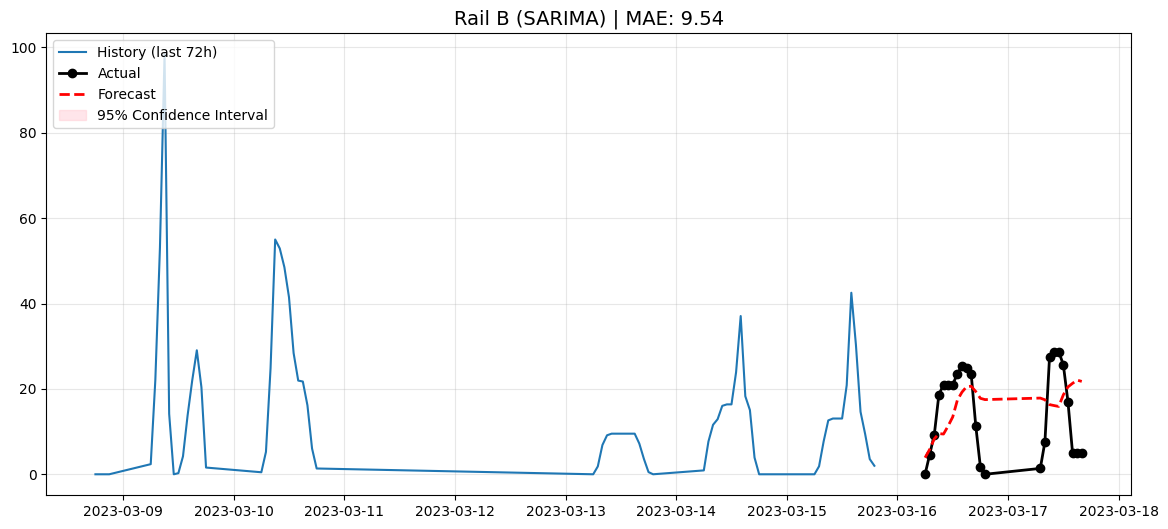

In [52]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def run_sarima_pipeline(ts, target_name, order=(1,0,1), seasonal_order=(1,1,1,24), h_ahead=24, split_date='2023-03-15 23:00:00'):
    """
    Fits SARIMA. If the mathematical calculation of the Confidence Interval fails (NaN),
    it reconstructs it empirically based on historical residuals.
    """
    # 1. Split Train/Test
    train = ts.loc[:split_date]
    test = ts.loc[pd.to_datetime(split_date) + pd.Timedelta(hours=1):].iloc[:h_ahead]
    
    # --- MEMORY FIX ---
    # Truncate history to avoid RAM explosion
    if len(train) > 2000:
        # print(f"   -> Reducing history to last 2000 hours...")
        train = train.iloc[-2000:]
    
    # 2. Fit Model
    # enforce_stationarity=False is crucial for complex seasonality to avoid crashes
    model = sm.tsa.statespace.SARIMAX(train, 
                                      order=order, 
                                      seasonal_order=seasonal_order, 
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
    
    print(f"Fitting SARIMA for {target_name}...")
    
    # Use low_memory=True (might cause NaNs in CI, but prevents MemoryError)
    results = model.fit(disp=False, low_memory=True)
    
    # 3. Forecast Base
    forecast_obj = results.get_forecast(steps=h_ahead)
    pred_mean = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int(alpha=0.05) # Tries to calculate mathematically
    
    # --- FALLBACK / LIFESAVER FOR NANs ---
    # Check if statsmodels returned NaNs for the Confidence Intervals
    if conf_int.isnull().values.any():
        print("   ⚠️ Warning: Statsmodels returned NaN for CIs. Calculating Empirical Interval...")
        
        # Calculate how much the model erred in the past (Standard Deviation of Residuals)
        resid_std = np.std(results.resid)
        
        # Fallback if resid_std is missing or zero
        if pd.isna(resid_std) or resid_std == 0:
            resid_std = pred_mean.mean() * 0.1 # Default to 10% error margin
        
        # Create the interval.
        # Formula: Prediction +/- 1.96 * StdDev * Sqrt(Time)
        # We multiply by sqrt(steps) because uncertainty grows over time
        steps = np.arange(1, h_ahead + 1)
        uncertainty_growth = np.sqrt(steps)
        
        margin_error = 1.96 * resid_std * uncertainty_growth
        
        # Reconstruct the DataFrame
        conf_int = pd.DataFrame(index=test.index)
        conf_int['lower'] = pred_mean - margin_error
        conf_int['upper'] = pred_mean + margin_error
        
        # Optional: Consumption cannot be negative
        conf_int['lower'] = conf_int['lower'].clip(lower=0)
        pred_mean = pred_mean.clip(lower=0)

    # Align indexes safely
    pred_mean.index = test.index
    conf_int.index = test.index
    
    # Rename columns to ensure consistency for plotting
    conf_int.columns = ['lower', 'upper']

    # 4. Calc Metrics
    mae = np.mean(np.abs(test - pred_mean))
    
    return {
        'model': results,
        'pred': pred_mean,
        'conf_int': conf_int,
        'test': test,
        'mae': mae
    }

def plot_probabilistic_forecast(res_dict, title):
    """Generates the plot required by the challenge - ROBUST VERSION"""
    plt.figure(figsize=(14, 6))
    
    # --- FIX CRASH: Safe Index Retrieval ---
    # Get the last data points used by the model
    history_to_plot = res_dict['model'].data.endog[-72:]
    
    # Try to retrieve dates. If .dates is None, use .row_labels (original Pandas index)
    if res_dict['model'].data.dates is not None:
        history_index = res_dict['model'].data.dates[-72:]
    else:
        history_index = res_dict['model'].data.row_labels[-72:]
    
    # Plot History
    plt.plot(history_index, history_to_plot, label='History (last 72h)')
    
    # Plot Actual (Test)
    plt.plot(res_dict['test'].index, res_dict['test'], 'ko-', linewidth=2, label='Actual')
    
    # Plot Forecast
    plt.plot(res_dict['pred'].index, res_dict['pred'], 'r--', linewidth=2, label='Forecast')
    
    # Plot Probabilistic Interval
    # Use iloc to be safe against column renaming
    plt.fill_between(res_dict['conf_int'].index, 
                     res_dict['conf_int'].iloc[:,0], 
                     res_dict['conf_int'].iloc[:,1], 
                     color='pink', alpha=0.4, label='95% Confidence Interval')
    
    plt.title(f"{title} | MAE: {res_dict['mae']:.2f}", fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()

# --- EXECUTION & NUMERICAL RESULTS ---
print(">>> Starting Execution with Robust Fixes...\n")

# 1. FLEET TOTAL
sarima_fleet_c = run_sarima_pipeline(fleet_ts['consumption'], "Fleet Consumption")

print(f"\n--- RESULTS: Fleet Consumption ---")
print(f"MAE: {sarima_fleet_c['mae']:.4f}")
print("First 5 predictions vs Actual:")
comparison = pd.DataFrame({
    'Forecast': sarima_fleet_c['pred'],
    'Actual': sarima_fleet_c['test'],
    'Diff': sarima_fleet_c['pred'] - sarima_fleet_c['test']
})
print(comparison.head(5))
plot_probabilistic_forecast(sarima_fleet_c, "Fleet Consumption (SARIMA)")


# 2. RAIL EXAMPLE (Rail B)
# Using a try-except block just in case
print("\n" + "="*50 + "\n")
try:
    rail_b_res = run_sarima_pipeline(rail_ts['consumption']['B'], "Rail B")
    
    print(f"\n--- RESULTS: Rail B Consumption ---")
    print(f"MAE: {rail_b_res['mae']:.4f}")
    print("First 5 predictions vs Actual:")
    comparison_b = pd.DataFrame({
        'Forecast': rail_b_res['pred'],
        'Actual': rail_b_res['test'],
        'Diff': rail_b_res['pred'] - rail_b_res['test']
    })
    print(comparison_b.head(5))
    
    plot_probabilistic_forecast(rail_b_res, "Rail B (SARIMA)")

except Exception as e:
    print(f"Error processing Rail B: {e}")

# LGBM MODEL